## Full example: Optimization of the marginal likelihood and prediction

### Sinusoidal toy data

We show how the marginal likelihood can be used after training a MAP network on a simple sinusoidal regression task.
Subsequently, we use the optimized LA to predict which provides uncertainty on top of the MAP prediction.
We also show how the `marglik_training` utility method can be used to jointly train the MAP and hyperparameters.
First, we set up the training data for the problem with observation noise \\(\sigma=0.3\\):

In [1]:
# import warnings
# warnings.simplefilter('ignore')

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import randint
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import torch.utils.data as data_utils

from laplace.baselaplace import FullLaplace
from laplace.curvature.backpack import BackPackGGN
import torch

from laplace import Laplace, marglik_training

from helpers import get_data, plot_data, IOHelper
from laplace_helper.util import plot_regression

In [2]:
N_POINTS_TEMP = 100  # per group

IO_HELPER = IOHelper('laplace_storage')

n_epochs = 100
batch_size = 1
torch.manual_seed(711)

torch.set_default_dtype(torch.float64)

data shapes: (100, 7) (100, 7) (100, 1) (100, 1)
rescaling data...
fitting...
transforming...
train mean: [ 5.77315973e-17  2.99760217e-16 -2.88657986e-16  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00]
train std: [1. 1. 1. 0. 0. 0. 0.]
test mean: [ 0.00843917 -0.21872054 -0.22718986  0.          0.          0.
  0.        ]
test std: [1.15963491 0.84052749 0.85906867 0.         0.         0.
 0.        ]
plotting data...


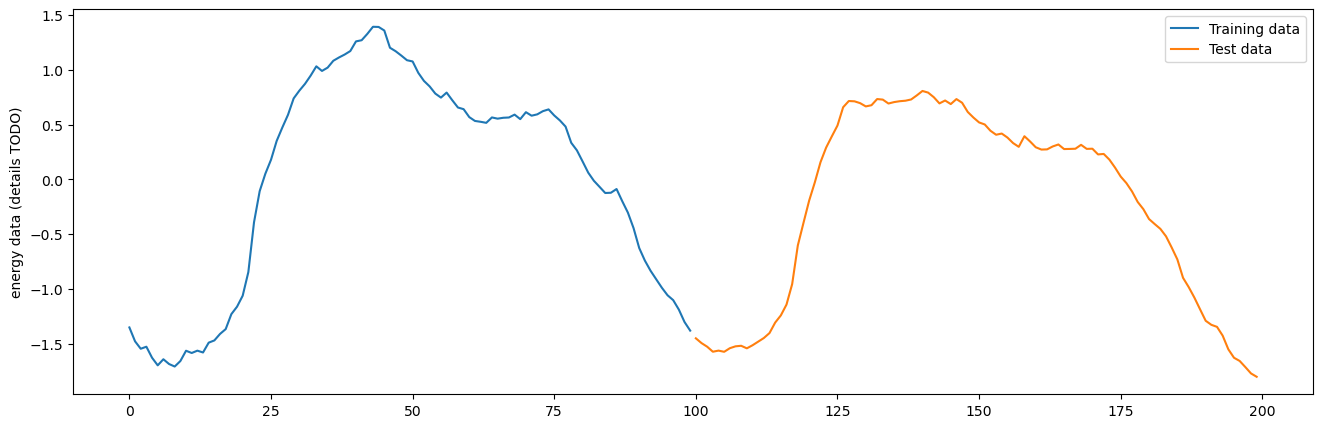

In [112]:
from sklearn.preprocessing import StandardScaler

def to_torch(data):
    try:
        data_np = data.values.astype('float')
    except AttributeError:
        data_np = data
    return torch.from_numpy(data_np)


data = (X_train, X_test, y_train, y_test) = get_data(N_POINTS_TEMP)
print('data shapes:', *(arr.shape for arr in data))

train_data = np.hstack((X_train, y_train))
test_data = np.hstack((X_test, y_test))

print('rescaling data...')
scaler = StandardScaler()

print('fitting...')
scaler.fit(train_data)

print('transforming...')
train_data = scaler.transform(train_data)
test_data = scaler.transform(test_data)

# unstack
X_train, y_train = np.hsplit(train_data, [-1])
X_test, y_test = np.hsplit(test_data, [-1])

for set_, X in [('train', X_train), ('test', X_test)]:
    print(f'{set_} mean: {X.mean(axis=0)}\n{set_} std: {X.std(axis=0)}')


data = (X_train, X_test, y_train, y_test) = map(to_torch, (X_train, X_test, y_train, y_test))

train_dataset = data_utils.TensorDataset(X_train, y_train)
train_loader = data_utils.DataLoader(train_dataset, batch_size=batch_size)

print('plotting data...')
plot_data(X_train, X_test, y_train, y_test)

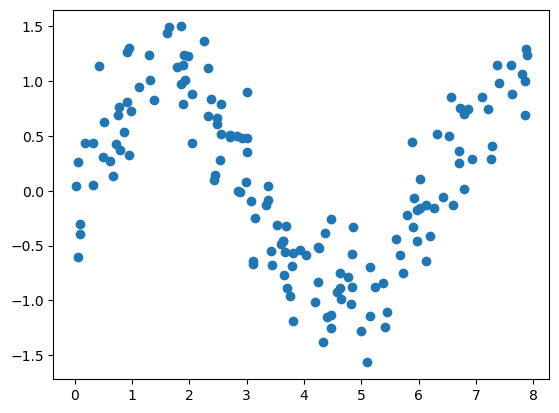

In [113]:
# temp
import torch
import torch.utils.data as data_utils

def get_sinusoid_example(n_data=150, sigma_noise=0.3, batch_size=150):
    # create simple sinusoid data set
    X_train = (torch.rand(n_data) * 8).unsqueeze(-1)
    y_train = torch.sin(X_train) + torch.randn_like(X_train) * sigma_noise
    train_loader = data_utils.DataLoader(
        data_utils.TensorDataset(X_train, y_train), batch_size=batch_size
    )
    X_test = torch.linspace(-5, 13, 500).unsqueeze(-1)
    return X_train, y_train, train_loader, X_test

# sample toy data example
X_train2, y_train2, train_loader2, X_test2 = get_sinusoid_example(sigma_noise=0.3)

import matplotlib.pyplot as plt


def unzip(iterable):
    return np.array(list(zip(*iterable)))


# plot data

X_train_sorted2, y_train_sorted2 = unzip(sorted(zip(X_train2.squeeze(), y_train2.squeeze())))

plt.scatter(X_train_sorted2, y_train_sorted2)

### Training a MAP

We now use `pytorch` to train a neural network with single hidden layer and Tanh activation.
The trained neural network will be our MAP estimate.
This is standard, so nothing new here, yet:

In [133]:
# create and train MAP model
def get_model():
    torch.manual_seed(711)
    return torch.nn.Sequential(
        torch.nn.Linear(7, 50), torch.nn.Tanh(), torch.nn.Linear(50, 1)
    )
model = get_model()

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

n_epochs = 20
for epoch in range(n_epochs):
    for X, y in train_loader:
        optimizer.zero_grad()
        loss = criterion(model(X), y)
        loss.backward()
        optimizer.step()
    # if epoch % 10 == 0:
    print(f'epoch {epoch} - loss {loss.item()}')
print('done!')
model.eval()

epoch 0 - loss 0.2686718009814226
epoch 1 - loss 0.17632370155744365
epoch 2 - loss 0.13538815568534912
epoch 3 - loss 0.09622121463525792
epoch 4 - loss 0.0667195257173551
epoch 5 - loss 0.044782826611147825
epoch 6 - loss 0.02902825219743418
epoch 7 - loss 0.01839291108194229
epoch 8 - loss 0.011749084234655607
epoch 9 - loss 0.007914326469375581
epoch 10 - loss 0.005860176434770542
epoch 11 - loss 0.004853364177120308
epoch 12 - loss 0.004441613148487857
epoch 13 - loss 0.004365544054618159
epoch 14 - loss 0.004478422405996638
epoch 15 - loss 0.004696336564894488
epoch 16 - loss 0.00497093311279393
epoch 17 - loss 0.005274329565520617
epoch 18 - loss 0.005590428295099827
epoch 19 - loss 0.0059099471897104345
done!


Sequential(
  (0): Linear(in_features=7, out_features=50, bias=True)
  (1): Tanh()
  (2): Linear(in_features=50, out_features=1, bias=True)
)

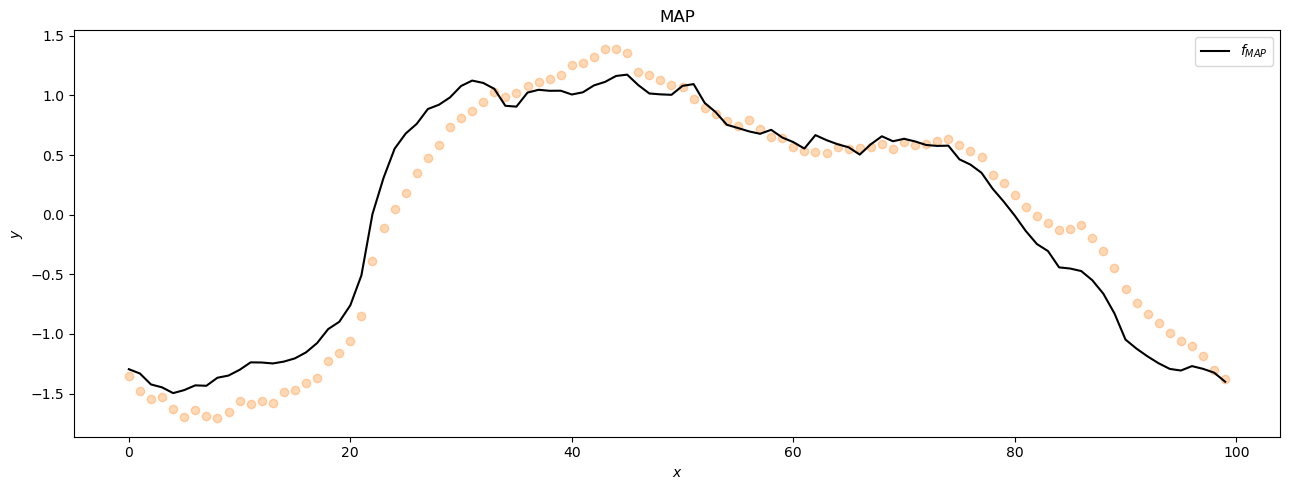

In [134]:
def plot_regression_map(X_train, y_train, X_test, f_test, figsize=(4.5, 2.8)):
    x_plot_train, x_plot_test = [np.arange(x_arr.shape[0]) for x_arr in [X_train, X_test]]
    
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.set_title("MAP")
    ax1.scatter(x_plot_train, y_train, alpha=0.3, color="tab:orange")
    ax1.plot(x_plot_test, f_test, color="black", label=r"$f_{MAP}$")
    ax1.legend()
    
    # ax1.set_ylim([-4, 6])
    # ax1.set_xlim([x_plot_test.min(), x_plot_test.max()])
    # ax2.set_xlim([x_plot_test.min(), x_plot_test.max()])
    ax1.set_ylabel("$y$")
    ax1.set_xlabel("$x$")
    plt.tight_layout()
    plt.show()

x = X_test.cpu()  # .numpy()
f_test = model(x).detach().numpy()

figsize = (13, 5)
plot_regression_map(X_train, y_train, X_test, f_test, figsize=figsize)

### Fitting and optimizing the Laplace approximation using empirical Bayes

With the MAP-trained model at hand, we can estimate the prior precision and observation noise
using empirical Bayes after training.
The `Laplace` method is called to construct a LA for `"regression"` with `"all"` weights.
As default `Laplace` returns a Kronecker factored LA, we use `"full"` instead on this small example.
We fit the LA to the training data and initialize `log_prior` and `log_sigma`.
Using Adam, we minimize the negative log marginal likelihood for `n_epochs`.

In [78]:
help(Laplace)

Help on function Laplace in module laplace.laplace:

Laplace(model: 'torch.nn.Module', likelihood: 'Likelihood | str', subset_of_weights: 'SubsetOfWeights | str' = <SubsetOfWeights.LAST_LAYER: 'last_layer'>, hessian_structure: 'HessianStructure | str' = <HessianStructure.KRON: 'kron'>, *args, **kwargs) -> 'BaseLaplace'
    Simplified Laplace access using strings instead of different classes.
    
    Parameters
    ----------
    model : torch.nn.Module
    likelihood : Likelihood or str in {'classification', 'regression'}
    subset_of_weights : SubsetofWeights or {'last_layer', 'subnetwork', 'all'}, default=SubsetOfWeights.LAST_LAYER
        subset of weights to consider for inference
    hessian_structure : HessianStructure or str in {'diag', 'kron', 'full', 'lowrank', 'gp'}, default=HessianStructure.KRON
        structure of the Hessian approximation (note that in case of 'gp',
        we are not actually doing any Hessian approximation, the inference is instead done in the functio

In [139]:
from timeit import default_timer

la = Laplace(model, "regression", subset_of_weights="all", hessian_structure="full")
t1 = default_timer()
la.fit(train_loader)  # todo: too slow?
t2 = default_timer()
print(f'time for fitting: {round(t2-t1)}s')  # ~140s

time for fitting: 138s


In [140]:
log_prior, log_sigma = torch.ones(1, requires_grad=True), torch.ones(1, requires_grad=True)
hyper_optimizer = torch.optim.Adam([log_prior, log_sigma], lr=1e-1)

n_epochs_lap = 1000
for epoch in range(n_epochs_lap):
    if epoch % (n_epochs_lap // 10) == 0:
        print('epoch:', epoch)
    hyper_optimizer.zero_grad()
    neg_marglik = - la.log_marginal_likelihood(log_prior.exp(), log_sigma.exp())
    neg_marglik.backward()
    hyper_optimizer.step()
print('done!')

epoch: 0
epoch: 100
epoch: 200
epoch: 300
epoch: 400
epoch: 500
epoch: 600
epoch: 700
epoch: 800
epoch: 900
done!


### Bayesian predictive

Here, we compare the MAP prediction to the obtained LA prediction.
For LA, we have a closed-form predictive distribution on the output \\(f\\) which is a Gaussian
\\(\mathcal{N}(f(x;\theta\_{MAP}), \mathbb{V}[f] + \sigma^2)\\):

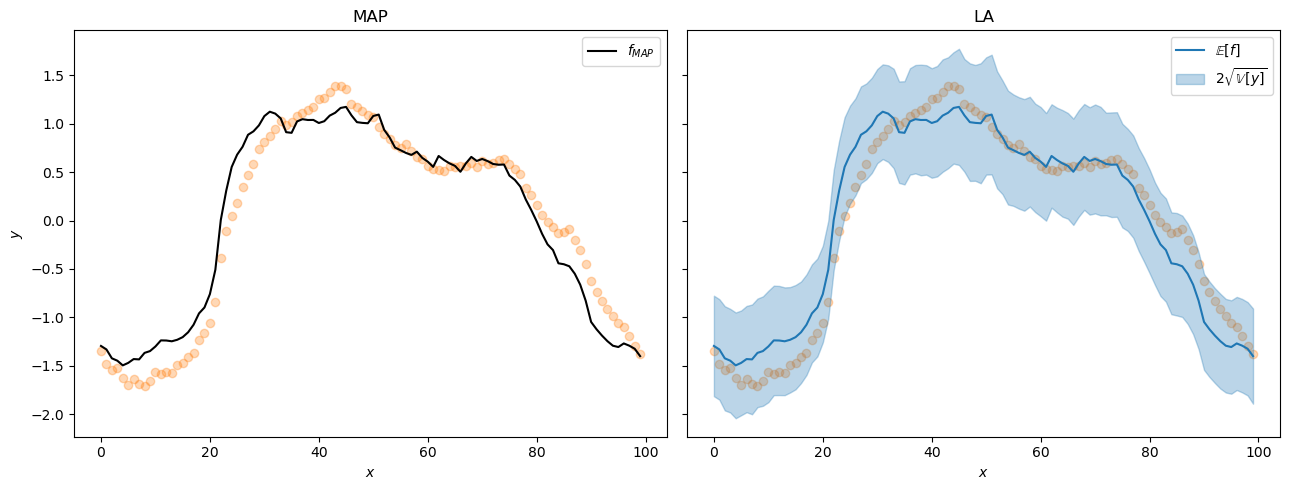

In [142]:
def plot_regression2(X_train, y_train, X_test, f_test, y_std, file_name="regression_example", figsize=(4.5, 2.8)):
    x_plot_train, x_plot_test = [np.arange(x_arr.shape[0]) for x_arr in [X_train, X_test]]
    
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=figsize)
    ax1.set_title("MAP")
    ax1.scatter(x_plot_train, y_train, alpha=0.3, color="tab:orange")
    ax1.plot(x_plot_test, f_test, color="black", label=r"$f_{MAP}$")
    ax1.legend()
    
    ax2.set_title("LA")
    ax2.scatter(x_plot_train, y_train, alpha=0.3, color="tab:orange")
    ax2.plot(x_plot_test, f_test, label=r"$\mathbb{E}[f]$")
    ax2.fill_between(
        x_plot_test,
        f_test - y_std * 2,
        f_test + y_std * 2,
        alpha=0.3,
        color="tab:blue",
        label=r"$2\sqrt{\mathbb{V}\,[y]}$",
    )
    ax2.legend()
    # ax1.set_ylim([-4, 6])
    # ax1.set_xlim([x_plot_test.min(), x_plot_test.max()])
    # ax2.set_xlim([x_plot_test.min(), x_plot_test.max()])
    ax1.set_ylabel("$y$")
    ax1.set_xlabel("$x$")
    ax2.set_xlabel("$x$")
    plt.tight_layout()
    plt.show()

# x = X_test.flatten().cpu().numpy()
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

figsize = (13, 5)
plot_regression2(X_train, y_train, X_test, f_mu, pred_std, figsize=figsize)

In comparison to the MAP, the predictive shows useful uncertainties.
When our MAP is over or underfit, the Laplace approximation cannot fix this anymore.
In this case, joint optimization of MAP and marginal likelihood can be useful.

### Jointly optimize MAP and hyperparameters using online empirical Bayes

We provide a utility method `marglik_training` that implements the algorithm proposed in [1].
The method optimizes the neural network and the hyperparameters in an interleaved way
and returns an optimally regularized LA.
Below, we use this method and plot the corresponding predictive uncertainties again:

In [149]:
model = get_model()
la, model, margliks, losses = marglik_training(
    model=model, train_loader=train_loader, likelihood="regression",
    hessian_structure="full", backend=BackPackGGN, n_epochs=n_epochs,
    optimizer_kwargs={"lr": 1e-3}, prior_structure="scalar"
)

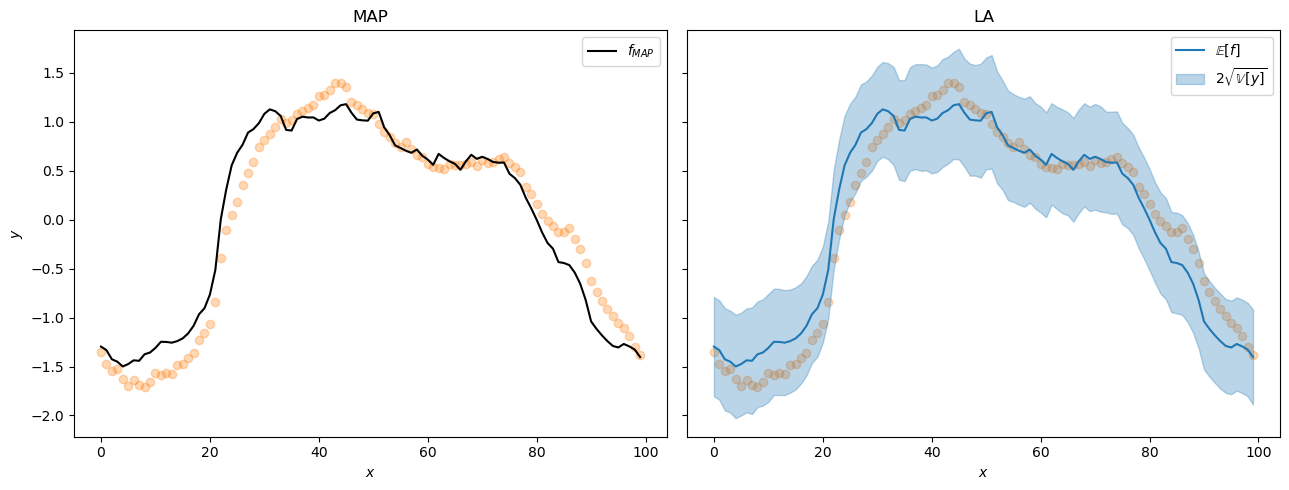

In [150]:
f_mu, f_var = la(X_test)
f_mu = f_mu.squeeze().detach().cpu().numpy()
f_sigma = f_var.squeeze().sqrt().cpu().numpy()
pred_std = np.sqrt(f_sigma**2 + la.sigma_noise.item()**2)

plot_regression2(X_train, y_train, X_test, f_mu, pred_std, figsize=figsize)